In [1]:
import pandas as pd
import plotnine as p9
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Helper functions

# Filter to include/exclude 'not provided' rows in series
def filter_notprovided(series, keep=False):
    from numpy import ndarray as nparr
    if keep:
        if type(series.iloc[0]) == nparr:
            return series.map(lambda x: x.tolist() == ['not provided'])
        elif type(series.iloc[0]) == np.int32:
            return series.map(pd.isnull)
        else:
            return series.map(lambda x: x == 'not provided')
    
    if type(series.iloc[0]) == nparr:
        return series.map(lambda x: x.tolist() != ['not provided'])
    elif type(series.iloc[0]) == np.int32:
            return series.map(pd.isnull)
    else:
        return series.map(lambda x: x != 'not provided')

# Length and percentage of df as part of whole df
def len_and_pct(partdf, wholedf):
    pct = f'{round(len(partdf)/float(len(wholedf))*100, 2)}%'
    return (len(partdf), pct)

# Abbreviate words
def abbrev(s):
    import re
    words = s.split()
    shortened = [re.sub('[\(\)]', '', x)[0:5] for x in words]
    return " ".join(shortened)

# Replace words with known abbreviations
def shorten(s):
    maps = {
        'unavailable': 'U',
        'degraded performance': 'P',
        'intermittent': 'I',
        'continuous': 'C',
        'visual': 'V',
        'some': 'SU',
        'all': 'AU',
        'single region': 'SR',
        'multiple regions': 'MR',
        'single availability zone': 'SAZ',
        'code error': 'CODE',
        'third party': '3P',
        'internal api issue': 'INTCOM',
        'increased load': 'LOAD',
        'internal network issue': 'INTCONN',
        'unhealthy unit': 'UNHLT',
        'configuration error': 'CFG',
        'maintenance side effect': 'MAINT',
        'deployment task': 'DEPLTSK',
        'shock event': 'SHOCK',
        'backend inefficiency': 'BKINEF',
        'environmental conditions': 'ENV',
        'nodes/devices/instances': 'UNIT',
        'external requests (apis)': 'EXTREQ',
        'storage': 'STOR',
        'internal communication interfaces': 'INTREQ',
        'external network/connectivity': 'EXTCONN',
        'processing backend': 'BKPROC',
        'certificates/licenses': 'CERT',
        'internal network': 'INTCONN',
        'user interface': 'UI',
        'everything': 'ALL',
        'one': '1',
        'multiple': '+'
    }
    return maps[s]


def export_graph(graphname, df, columns, plot):
    print('Not provided:')
    for c in columns:
        with open("../report/src/numbers/"+"np-"+graphname+"-"+c+".tex", "w") as f:
            f.write("%d (%s)" % len_and_pct(df[filter_notprovided(df[c], keep=True)], df))
        print(f'- {c}: {"%d (%s)" % len_and_pct(df[filter_notprovided(df[c], keep=True)], df)}')

    plot.save("../report/src/images/"+graphname+".png")
    print(plot)
    
# Colorblind-friendly colors from: http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/#a-colorblind-friendly-palette
colorblindPalette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
disc_colorpalette = p9.scale_color_manual(values=colorblindPalette)
disc_fillpalette = p9.scale_fill_manual(values=colorblindPalette)
disc_fillpalette_larger = p9.scale_fill_brewer(type='qual', palette="Paired")
cont_fillpalette = p9.scale_fill_gradient(low="blue", high="red")

In [2]:
df = pd.read_parquet("../data/preprocessed.parquet")

# These columns are pointless to plot, and take a long time
df.drop(labels=['description', 'service_id'], axis=1, inplace=True)
df.columns

Index(['services', 'severity', 'range', 'users', 'cause', 'duration',
       'affected', 'service_name', 'location', 'status', 'vendor',
       'first_notification', 'last_notification', 'monitor', 'org_type',
       'half_desc', 'duration_min', 'hour_of_week'],
      dtype='object')

Not provided:
- range: 8 (1.11%)
- services: 14 (1.95%)
- cause: 530 (73.71%)


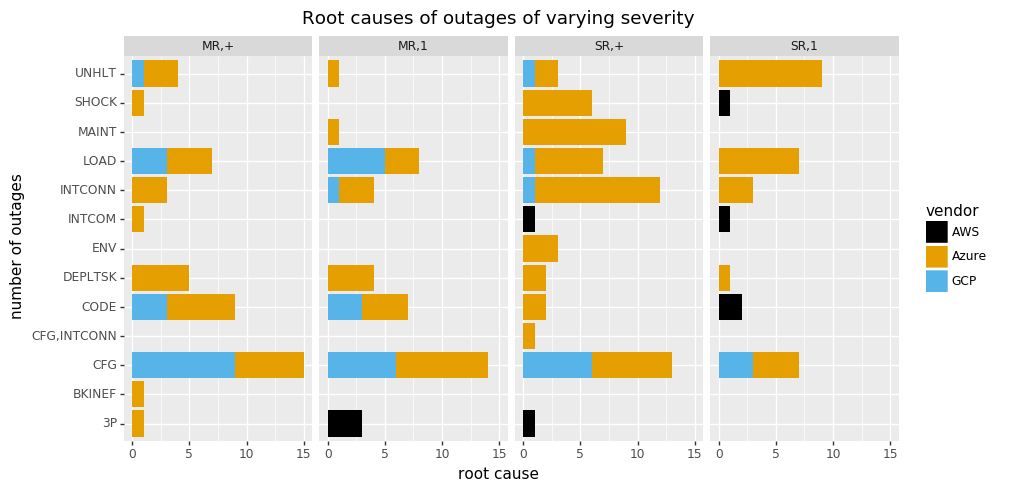

<ggplot: (304543121)>


In [3]:
# Removing single availability zone because only applies to AWS
subdf = df[['range', 'services', 'vendor', 'cause']].query('range != "single availability zone"')

filt = subdf[filter_notprovided(subdf.cause) & filter_notprovided(subdf.range) & filter_notprovided(subdf.services)]

plotdf = pd.DataFrame({'range_services': filt[['range', 'services']].applymap(shorten).agg(','.join, axis=1),
                       'cause': filt.cause.map(lambda x: ','.join(map(shorten, x))),
                       'vendor': filt.vendor})


export_graph("root-causes-by-severity", subdf, ['range', 'services', 'cause'],
             (p9.ggplot(plotdf)
              + p9.aes(x='cause', fill='vendor') 
              + p9.geom_bar()
              + p9.coord_flip()
              + p9.theme(figure_size=(10,5))
              + disc_fillpalette
              + p9.facet_grid("~ range_services")
              + p9.labs(x="number of outages", y="root cause")
              + p9.ggtitle("Root causes of outages of varying severity")))

In [4]:
scale_x_hours_as_dow = p9.scale_x_continuous(breaks=range(0,24*8, 24), minor_breaks=1, labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', ''])

Not provided:
- hours: 0 (0.0%)


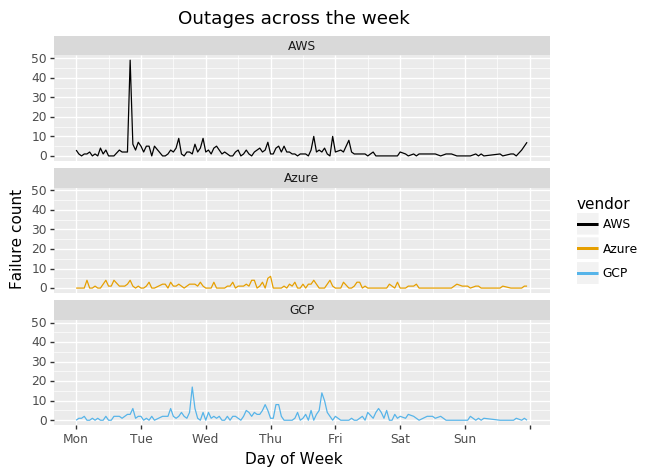

<ggplot: (307331569)>


In [5]:
azure_hours = df[df.vendor == "Azure"].hour_of_week.value_counts()
aws_hours = df[df.vendor == "AWS"].hour_of_week.value_counts()
gcp_hours = df[df.vendor == "GCP"].hour_of_week.value_counts()

plotdf = (pd.DataFrame({'Azure': azure_hours,
                       'GCP': gcp_hours,
                       'AWS': aws_hours})
          .applymap(lambda x: 0 if pd.isna(x) else x)
          .reset_index().rename(columns={"index": "hours"}))

export_graph("outages-across-week", plotdf, ['hours'],
             (p9.ggplot(plotdf.melt(id_vars='hours', var_name='vendor', value_name='outages_count'))
              + p9.aes(x='hours', y='outages_count', color='vendor')
              + p9.geom_line()
              + scale_x_hours_as_dow
              + p9.labs(x='Day of Week', y='Failure count')
              + p9.facet_wrap('vendor', nrow=3, ncol=1)
              + disc_colorpalette
              + p9.scale_color_manual(values=colorblindPalette)
              + p9.ggtitle("Outages across the week")))

Not provided:
- cause: 565 (74.83%)
- hour_of_week: 0 (0.0%)


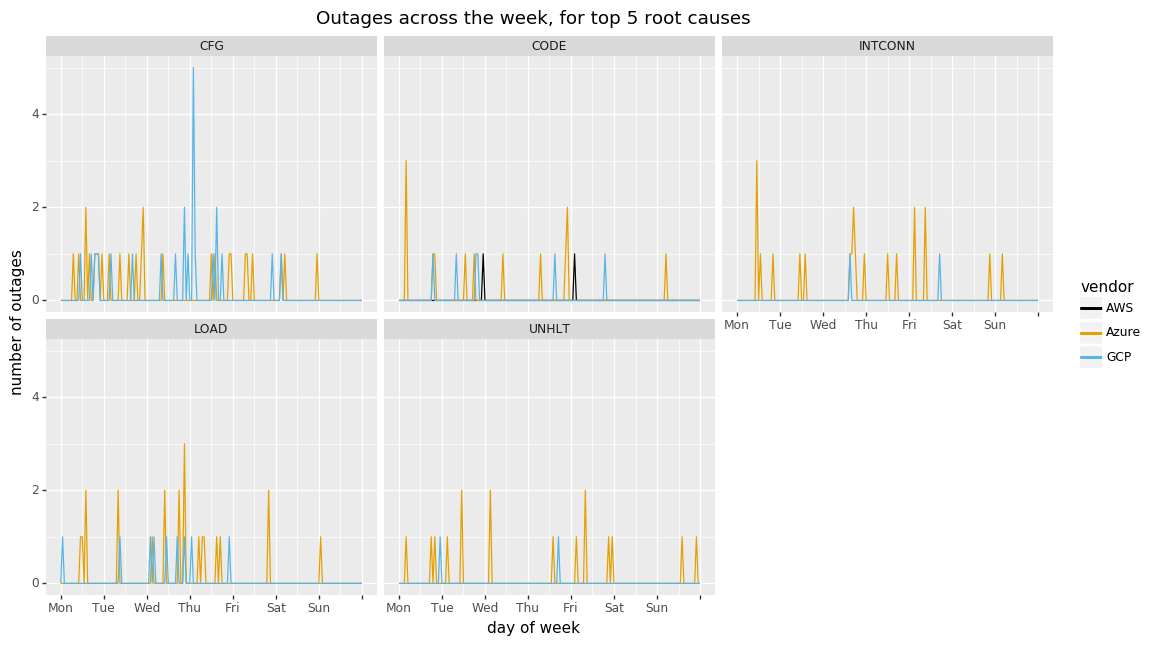

<ggplot: (307871225)>


In [6]:
filt = df[filter_notprovided(df.cause) & df.hour_of_week.notna()]

plotdf = pd.DataFrame({'vendor': filt.vendor,
                       'cause': filt.cause.map(lambda x: ','.join(map(shorten, x))),
                       'hour_of_week': filt.hour_of_week})
top_5_cause = plotdf.cause.value_counts()[0:5].index

plotdf = (plotdf[plotdf.cause.isin(top_5_cause)]
          .melt(id_vars=['vendor', 'cause'], value_name='hour_of_week')
          .drop('variable', axis='columns')
          .groupby(['vendor', 'cause'])
          .hour_of_week.value_counts().reset_index(name='num_outages'))

for vd in set(plotdf.vendor.values):
    for cuz in set(plotdf[plotdf.vendor == vd].cause.values):
        for i in range(24*7+1):
            if len(plotdf[(plotdf.vendor == vd) & (plotdf.cause == cuz) & (plotdf.hour_of_week == i)]) == 0:
                plotdf = plotdf.append({'vendor': vd, 'cause': cuz, 'hour_of_week': i, 'num_outages': 0}, ignore_index=True)

export_graph("components-across-week", df, ['cause', 'hour_of_week'],
             (p9.ggplot(plotdf)
              + p9.aes(x='hour_of_week', y='num_outages', color='vendor')
              + p9.geom_line()
              + p9.facet_wrap('~ cause')
              + p9.scale_y_continuous(breaks=lambda x: range(0, int(np.ceil(x[1])), 2))
              + scale_x_hours_as_dow
              + p9.labs(x='day of week', y='number of outages')
              + p9.theme(figure_size=(13,7))
              + disc_colorpalette
              + p9.ggtitle("Outages across the week, for top 5 root causes")))

Not provided:
- cause: 565 (74.83%)
- duration_min: 0 (0.0%)


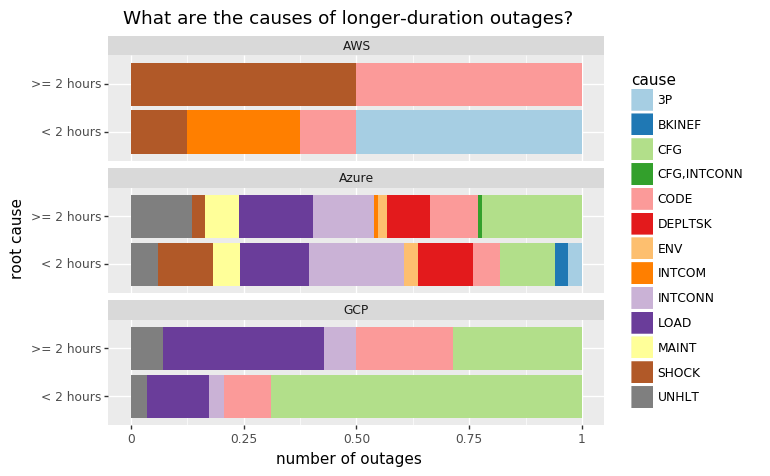

<ggplot: (304541905)>


In [7]:
filtered = df[filter_notprovided(df.cause) & (df.duration_min >= 0)]
plotdf = (pd.DataFrame({'cause': filtered.cause.map(lambda x: ','.join(map(shorten, x))),
                       'duration_min': filtered.duration_min,
                       'duration_comp': filtered.duration_min.map(lambda x: "< 2 hours" if (x/60.0) < 2 else ">= 2 hours"),
                       'vendor': filtered.vendor}))

normdf = plotdf.groupby(['vendor', 'duration_comp']).cause.value_counts(normalize=True).reset_index(name="counts")

with open("../report/src/numbers/components-vs-duration-n-wrong-times.tex", "w") as f:
    f.write("%d" % len(df[df.duration_min < 0]))

export_graph("causes-vs-duration", df, ['cause', 'duration_min'],
            (p9.ggplot(normdf)
             + p9.aes(x='duration_comp', y='counts', fill='cause')
             + p9.facet_wrap('~ vendor', ncol=1)
             + p9.geom_col()
             + p9.coord_flip()
             + disc_fillpalette_larger
             + p9.labs(y="number of outages", x="root cause")
             + p9.ggtitle("What are the causes of longer-duration outages?")))

Not provided:
- users: 5 (0.66%)
- range: 8 (1.06%)


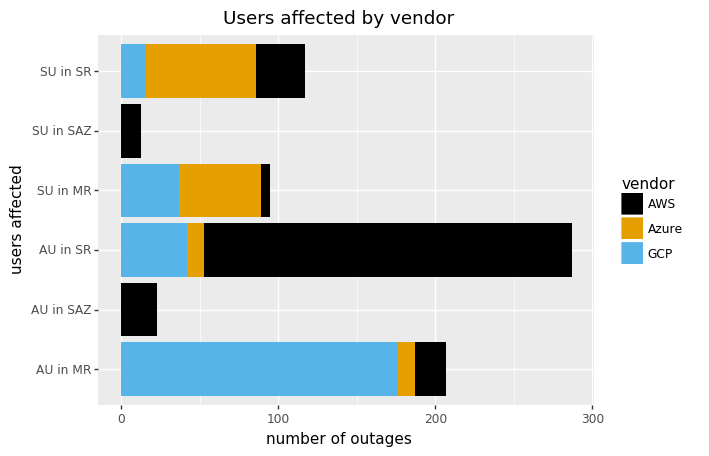

<ggplot: (309417797)>


In [8]:
filt = df[filter_notprovided(df.users) & filter_notprovided(df.range)]
plotdf = pd.DataFrame({'users_range': filt.users.map(shorten)+' in '+filt.range.map(shorten),
                       'vendor': filt.vendor})
export_graph("users-affected-by-vendor", df, ['users', 'range'],
             (p9.ggplot(plotdf)
              + p9.aes(x='users_range', fill='vendor')
              + p9.geom_bar()
              + p9.labs(x='users affected', y='number of outages')
              + p9.coord_flip()
              + disc_fillpalette
              + p9.ggtitle("Users affected by vendor")))

Not provided:
- users: 5 (0.66%)
- range: 8 (1.06%)
- severity: 72 (9.54%)
- duration: 67 (8.87%)


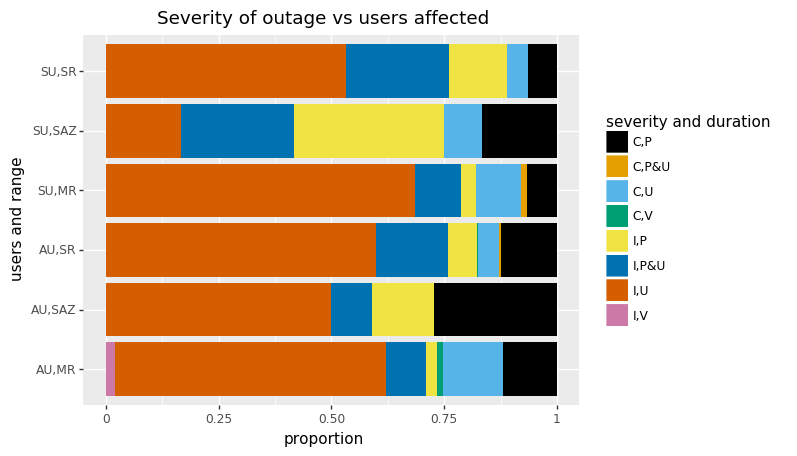

<ggplot: (309424541)>


In [9]:
filt = df[filter_notprovided(df.users) & filter_notprovided(df.range) & filter_notprovided(df.severity) & filter_notprovided(df.duration)]
plotdf = (pd.DataFrame({'users and range': filt.users.map(shorten)+','+filt.range.map(shorten),
                       'severity and duration': (filt.duration.map(shorten)
                                                 +','
                                                 +filt.severity.map(lambda x: '&'.join(map(shorten, x))))})
          .groupby(['users and range'])
          ['severity and duration'].value_counts(normalize=True)
          .reset_index(name='proportion'))

export_graph("severity-vs-users-affected", df, ['users', 'range', 'severity', 'duration'],
             (p9.ggplot(plotdf)
              + p9.ggtitle("Severity of outage vs users affected")
              + p9.aes(x='users and range', y='proportion', fill='severity and duration')
              + disc_fillpalette
              + p9.coord_flip()
              + p9.geom_col()))

Not provided:
- cause: 565 (74.83%)
- range: 8 (1.06%)
- users: 5 (0.66%)


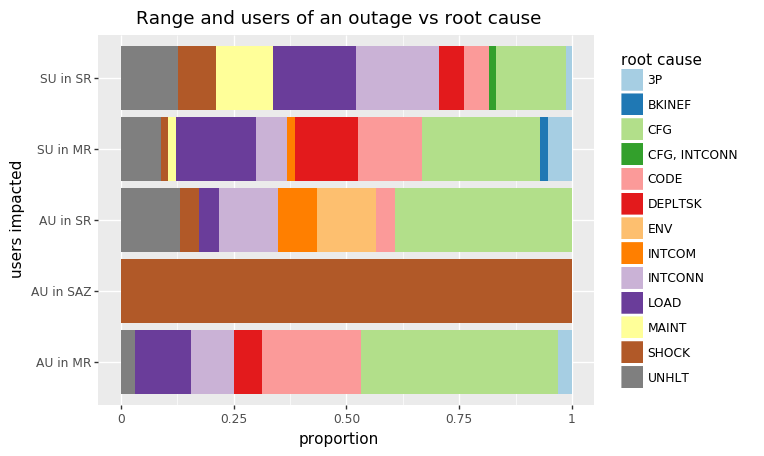

<ggplot: (309077937)>


In [10]:
filt = df[filter_notprovided(df.cause) & filter_notprovided(df.range) & filter_notprovided(df.users)]
plotdf = (pd.DataFrame({'cause': filt.cause.map(lambda x: ', '.join(map(shorten, x))), 
                       'range_users': filt.users.map(shorten)+' in '+filt.range.map(shorten)})
          .groupby('range_users')
          .cause.value_counts(normalize=True)
          .reset_index(name='proportion'))

export_graph("range-users-vs-root-cause", df, ['cause', 'range', 'users'],
             (p9.ggplot(plotdf)
              + p9.aes(x='range_users', y='proportion',  fill='cause')
              + p9.geom_col()
              + p9.scale_fill_brewer(type='qual', palette="Paired") # the colorblind-friendly palette is too small here
              + p9.coord_flip()
              + p9.labs(x='users impacted', fill='root cause')
              + p9.ggtitle("Range and users of an outage vs root cause")))

In [11]:
# I'm not getting the same results...

# filt = df[filter_notprovided(df.users) & filter_notprovided(df.severity)][['duration_min', 'vendor', 'severity', 'users']]
# filt.severity = filt.severity.map(lambda x: 'O' if len(x) > 1 else x[0][0].upper())
# filt.users = filt.users.map(lambda x: x[0].upper())
# plotdf = pd.DataFrame(columns=['vendor', 'severity', 'variable', 'proportion'])
# filt.severity = filt[['severity', 'users']].apply(','.join, axis='columns').map(lambda x: 'O' if x[0] in ['O', 'V'] else x)
# filt = filt.drop('users', axis='columns')

# prop_counts = filt.drop('duration_min', axis='columns').groupby('vendor').severity.value_counts(normalize=True).reset_index(name='proportion')

# total_durations = filt[['vendor', 'duration_min']].groupby('vendor').agg(sum)

# prop_durations = filt.groupby(['vendor', 'severity']).duration_min.agg(sum).reset_index(name='duration')
# prop_durations = prop_durations.apply(lambda x: {'vendor': x.vendor, 'severity': x.severity, 'proportion': float(x.duration)/total_durations.at[x.vendor, 'duration_min']}, axis='columns', result_type='expand')
# plotdf = pd.concat([plotdf, 
#                     pd.DataFrame({'vendor': prop_counts.vendor, 'severity': prop_counts.severity, 'variable': ['count']*len(prop_counts), 'proportion': prop_counts.proportion}),
#                     pd.DataFrame({'vendor': prop_durations.vendor,
#                                   'severity': prop_durations.severity, 
#                                   'variable': ['duration']*len(prop_durations), 
#                                   'proportion': prop_durations.proportion})
#                    ])


# (p9.ggplot(plotdf)
#  + p9.aes(x='vendor', y='proportion', fill='severity')
#  + p9.geom_col(color='black')
#  + p9.facet_wrap('variable', nrow=2, ncol=1)
#  + p9.coord_flip())

In [12]:
# from itertools import combinations, chain
# import numpy as np

# def powerset_noempty(iterable):
#     s = list(iterable)
#     return list(filter(bool, map(list, chain.from_iterable(list(combinations(s, r)) for r in range(len(s)+1)))))

# def islist(col):
#     return col.map(type).eq(np.ndarray).all()
# def isstr(col):
#     return col.map(type).eq(str).all()

# def abbrev(s):
#     import re
#     words = s.split()
#     shortened = [re.sub('[\(\)]', '', x)[0:5] for x in words]
#     return " ".join(shortened)

# plots = []
# for pair in list(combinations(df.columns, 2)):
    
#     if isstr(df[pair[0]]) and isstr(df[pair[1]]):
#         plotpart = p9.ggplot(df, p9.aes(x=pair[0], y=pair[1]))
        
#     else:
#         # Make a temp dataframe to hold reformatted values
#         df_tmp = pd.DataFrame()
#         if islist(df[pair[0]]):
#             df_tmp[pair[0]] = df[pair[0]].apply(lambda x: ','.join(map(abbrev, x)))
#         else:
#             df_tmp[pair[0]] = df[pair[0]]
            
#         if islist(df[pair[1]]):
#             df_tmp[pair[1]] = df[pair[1]].apply(lambda x: ','.join(map(abbrev, x)))
#         else:
#             df_tmp[pair[1]] = df[pair[1]]
        
#         plotpart = p9.ggplot(df_tmp, p9.aes(x=pair[0], y=pair[1]))

    
#     if pair[0] == 'hour_of_week':       
#         plots.append(plotpart
#                      + p9.geom_jitter()
#                      + p9.scales.xlim(0, 24*7))
#     elif pair[1] == 'hour_of_week':
#         plots.append(plotpart
#                      + p9.geom_jitter() 
#                      + p9.scales.ylim(0, 24*7))
#     else:
#         plots.append(plotpart + dsp_opt)